# Setup

In [1]:
using Pkg
Pkg.activate("SCC", shared=true)


import QuantumToolbox as qt
using Logging
import CairoMakie as cm
using MiniLoggers
using Revise
using Dates

using DimensionalData

using RecursiveArrayTools
using Tensors
using ProgressLogging

using YAXArrays

import LsqFit

import JSON3
import CSV

using IJulia
if isdefined(Main, :IJulia)
    Main.IJulia.stdio_bytes[] = 0;
end

  Activating project at `~/.julia/environments/SCC`
[ Info: Precompiling QuantumToolbox [6c2fb7c5-b903-41d2-bc5e-5a7c320b9fab] (cache misses: wrong dep version loaded (4), dep missing source (2))
ERROR: LoadError: ArgumentError: Platform `riscv64-linux-gnu-libgfortran5` is not an officially supported platform
Stacktrace:
 [1] parse(::Type{Base.BinaryPlatforms.Platform}, triplet::String; validate_strict::Bool)
   @ Base.BinaryPlatforms ./binaryplatforms.jl:752
 [2] parse(::Type{Base.BinaryPlatforms.Platform}, triplet::String)
   @ Base.BinaryPlatforms ./binaryplatforms.jl:691
 [3] (::OpenSpecFun_jll.var"#parse_wrapper_platform#1")(x::Any)
   @ OpenSpecFun_jll ~/.julia/packages/JLLWrappers/jXOYx/src/toplevel_generators.jl:113
 [4] (::OpenSpecFun_jll.var"#make_wrapper_dict#2"{OpenSpecFun_jll.var"#parse_wrapper_platform#1"})(dir::Any, x::Any)
   @ OpenSpecFun_jll ~/.julia/packages/JLLWrappers/jXOYx/src/toplevel_generators.jl:145
 [5] top-level scope
   @ ~/.julia/packages/JLLWrappers/jXOYx

LoadError: Failed to precompile QuantumToolbox [6c2fb7c5-b903-41d2-bc5e-5a7c320b9fab] to "/Users/gavinrockwood/.julia/compiled/v1.11/QuantumToolbox/jl_lHBjd3".

In [3]:
import SuperconductingCavities as SC


[ Info: new driver key :netcdf, updating backendlist.


## Logging Setup

In [4]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)


ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), Info, Base.CoreLogging.default_metafmt, true, 0, Dict{Any, Int64}())

# Ionization Test

In [7]:
Model = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

Dict{String, Any} with 7 entries:
  "pulse_time" => 205.054
  "Envelope Args" => Dict{String, Any}("pulse_time"=>205.054, "k"=>2, "ramp_time"=>11.6257)
  "epsilon" => 0.735
  "Envelope" => "Bump_Ramp"
  "shift" => 0.0376647
  "accuracy" => 0.999605
  "freq_d" => -2.86996


11-element Vector{Float64}:
 0.0
 0.020000000000000004
 0.04000000000000001
 0.06
 0.08000000000000002
 0.1
 0.12
 0.13999999999999999
 0.16000000000000003
 0.18000000000000002
 0.2

[2024-12-16 23:19:11] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


[2024-12-16 23:19:25] Info: Done With Floquet Sweep
[2024-12-16 23:19:25] Info: Fit Stuff: 3-element Vector{Float64}:	 0.07711608528644685	 0.00309190469660559	 2.2828624321699205


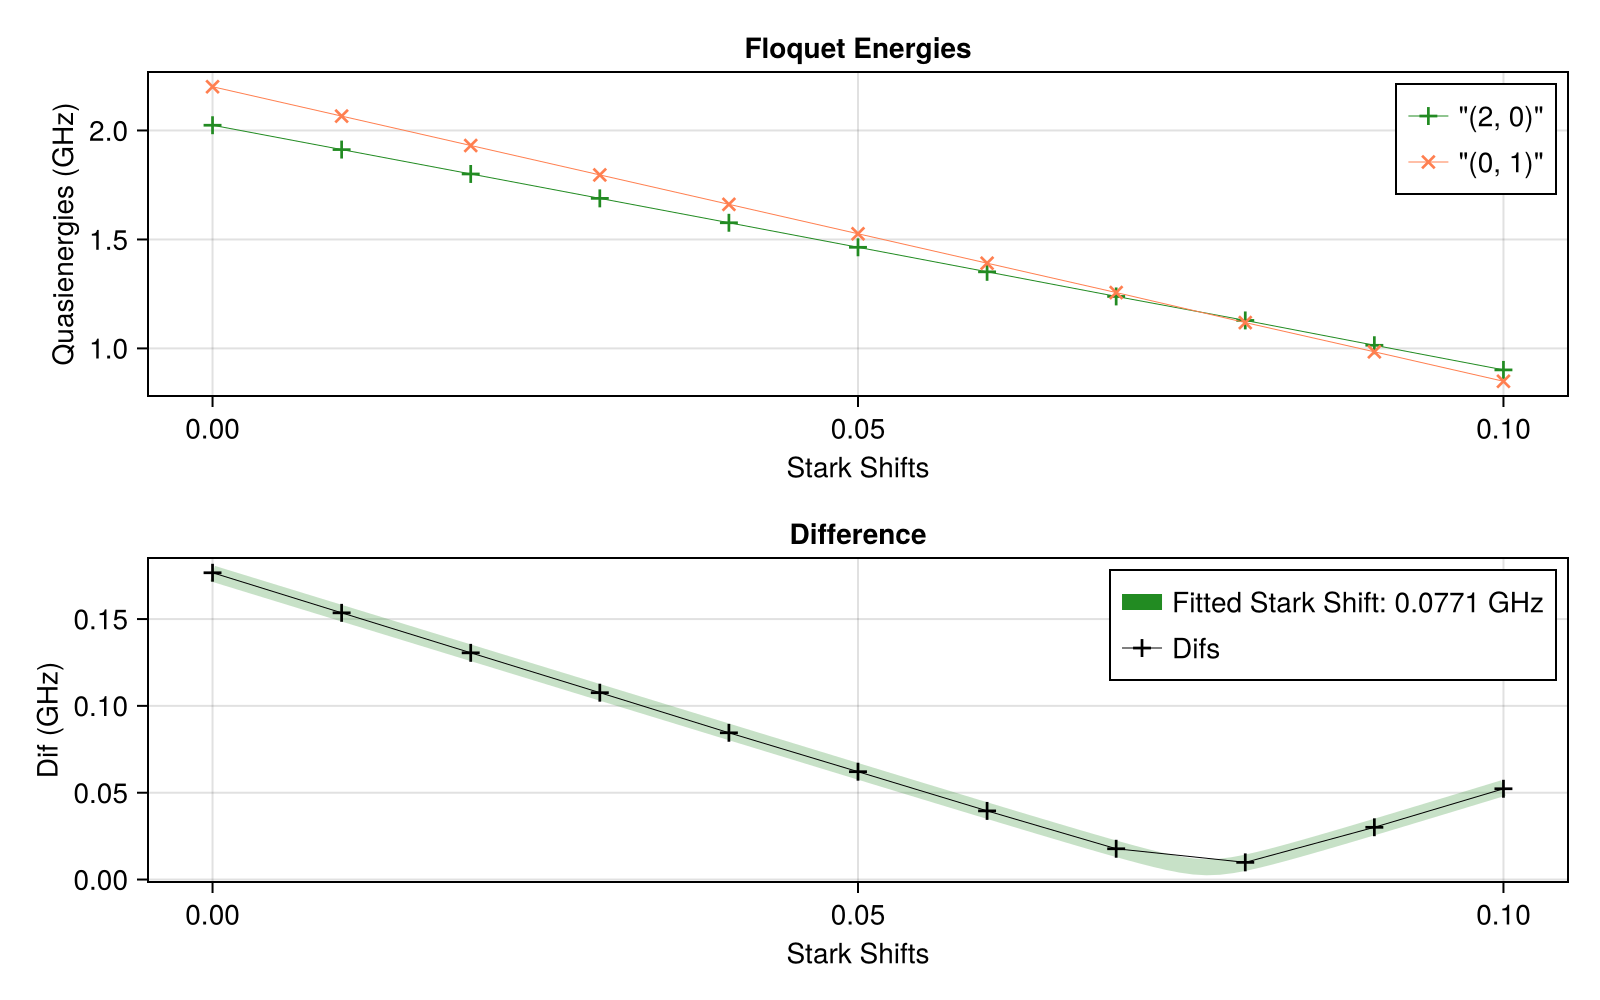

2-element Vector{Float64}:
   0.07711608528644685
 141.67530615975033

In [51]:
ε = 1.0766612
shifts = collect(LinRange(0, 0.1, 11))

SC.Dynamics.FindStarkShift(Model, (2,0), (0,1), ε, shifts)

## Planning .jl run file

For this, i am going to pick a stark shift and sweep drive strength, this should allow the state tracking to work best. 

In [60]:
params

1-element Vector{Any}:
 Dict{Any, Any}("ε" => 1.1, "ν" => -2.8299623474273465)

In [61]:
freq_d = Model.dressed_energies[(0,1)]-Model.dressed_energies[(2,0)]
εs = collect(LinRange(0.7, 1.1, 10));
shift = 0.04

params = []

for i in 1:length(εs)
    push!(params, Dict{Any,Any}())
    params[end]["ε"] = εs[i]
    params[end]["ν"] = shift+freq_d
end

println(params)

floq_sweep_res = SC.Dynamics.Floquet_t0_Sweep(Model, params; states_to_track=Model.dressed_states);


Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.8299623474273465), Dict{Any, Any}("ε" => 0.7444444444444444, "ν" => -2.8299623474273465), Dict{Any, Any}("ε" => 0.7888888888888889, "ν" => -2.8299623474273465), Dict{Any, Any}("ε" => 0.8333333333333334, "ν" => -2.8299623474273465), Dict{Any, Any}("ε" => 0.8777777777777778, "ν" => -2.8299623474273465), Dict{Any, Any}("ε" => 0.9222222222222223, "ν" => -2.8299623474273465), Dict{Any, Any}("ε" => 0.9666666666666668, "ν" => -2.8299623474273465), Dict{Any, Any}("ε" => 1.011111111111111, "ν" => -2.8299623474273465), Dict{Any, Any}("ε" => 1.0555555555555556, "ν" => -2.8299623474273465), Dict{Any, Any}("ε" => 1.1, "ν" => -2.8299623474273465)]
[2024-12-16 23:28:49] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


[2024-12-16 23:29:01] Info: Done With Floquet Sweep
[2024-12-16 23:29:01] Info: Tracking State
[2024-12-16 23:29:01] Info: Running the necessary time evolutions


In [87]:
quasienergies = Dict{Any, Any}()
states = keys(Model.dressed_energies)

for state in states
    quasienergies[state] = [floq_sweep_res[State = At(string(state))].data[i]["Quasienergies"] for i in 1:length(εs)]
end

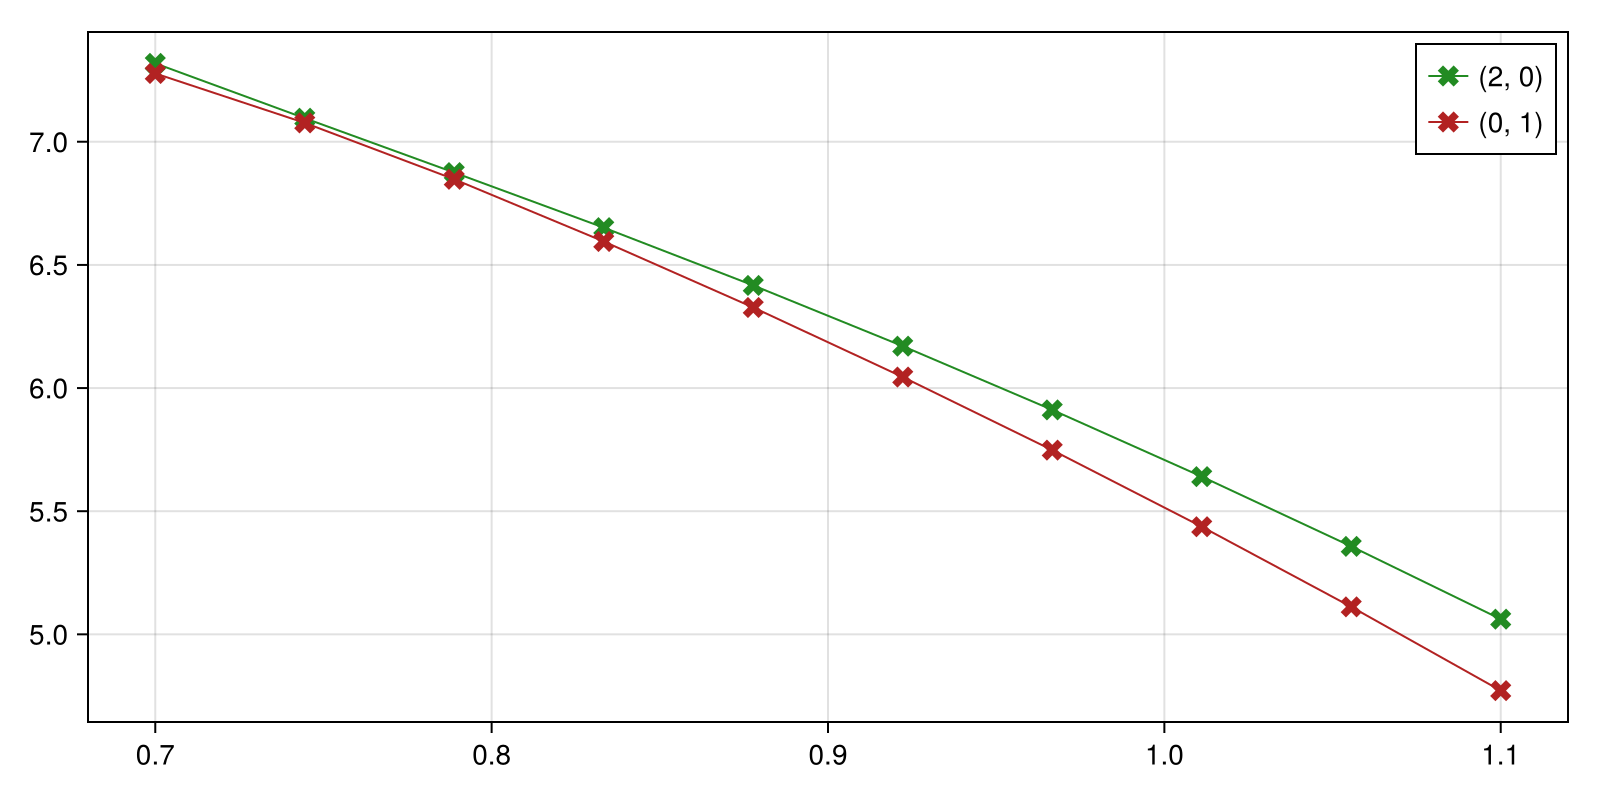

CairoMakie.Screen{IMAGE}


In [96]:
fig = cm.Figure(size = (800, 400))
ax = cm.Axis(fig[1,1])

state = (2,0)
cm.scatterlines!(ax, εs, quasienergies[state], color = "forestgreen", marker = :x, linewidth = 1, markersize = 15, label = string(state))

state = (0,1)
cm.scatterlines!(ax, εs, quasienergies[state], color = "firebrick", marker = :x, linewidth = 1, markersize = 15, label = string(state))



cm.axislegend(ax)
display(fig)

In [149]:
freq_d = Model.dressed_energies[(0,1)]-Model.dressed_energies[(2,0)]
εs = collect(LinRange(0.7, 1.1, 30));
shifts = collect(LinRange(0.03, 0.1, 30))
states = keys(Model.dressed_energies)
quasienergies = fill(0.0, Dim{:state}(string.(states)), Dim{:eps}(εs), Dim{:shift}(shifts))


for j in 1:length(shifts)
    @info "Doing Shift Number: $(j)"
    params = []
    for i in 1:length(εs)
        push!(params, Dict{Any,Any}())
        params[end]["ε"] = εs[i]
        params[end]["ν"] = shifts[j]+freq_d
    end

    println(params)

    floq_sweep_res = SC.Dynamics.Floquet_t0_Sweep(Model, params; states_to_track=Model.dressed_states);

    

    for state in states
        #quasienergies[shifts[j]][state] = [floq_sweep_res[State = At(string(state))].data[i]["Quasienergies"] for i in 1:length(εs)]
        quasienergies[state = At(string(state)), shift=At(shifts[j])] = [floq_sweep_res[State = At(string(state))].data[i]["Quasienergies"] for i in 1:length(εs)]
    end

end

[2024-12-17 00:23:34] Info: Doing Shift Number: 1
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.8517241379310345, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.8655172413793104, "ν" => -2.8399623474273468), Dict{Any, Any}("ε" => 0.879310344827586

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2024-12-17 00:24:13] Info: Done With Floquet Sweep
[2024-12-17 00:24:13] Info: Tracking State
[2024-12-17 00:24:13] Info: Running the necessary time evolutions
[2024-12-17 00:24:13] Info: Doing Shift Number: 2
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.8375485543238983), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.8375485543238983), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.8375485543238983), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.8375485543238983), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.8375485543238983), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.8375485543238983), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.8375485543238983), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.8375485543238983), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.8375485543238983), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.8375485543238983), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.8375485543238983), Dict{Any, Any}("ε" =

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2024-12-17 00:24:52] Info: Done With Floquet Sweep
[2024-12-17 00:24:52] Info: Tracking State
[2024-12-17 00:24:52] Info: Running the necessary time evolutions
[2024-12-17 00:24:52] Info: Doing Shift Number: 3
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.83513476122045), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.83513476122045), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.83513476122045), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.83513476122045), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.83513476122045), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.83513476122045), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.83513476122045), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.83513476122045), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.83513476122045), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.83513476122045), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.83513476122045), Dict{Any, Any}("ε" => 0.8517241379310345, 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2024-12-17 00:25:31] Info: Done With Floquet Sweep
[2024-12-17 00:25:31] Info: Tracking State
[2024-12-17 00:25:31] Info: Running the necessary time evolutions
[2024-12-17 00:25:31] Info: Doing Shift Number: 4
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.832720968117002), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.832720968117002), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.832720968117002), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.832720968117002), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.832720968117002), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.832720968117002), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.832720968117002), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.832720968117002), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.832720968117002), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.832720968117002), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.832720968117002), Dict{Any, Any}("ε" => 0.8517241

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


[2024-12-17 00:26:10] Info: Done With Floquet Sweep
[2024-12-17 00:26:10] Info: Tracking State
[2024-12-17 00:26:10] Info: Running the necessary time evolutions
[2024-12-17 00:26:10] Info: Doing Shift Number: 5
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.8303071750135533), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.8303071750135533), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.8303071750135533), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.8303071750135533), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.8303071750135533), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.8303071750135533), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.8303071750135533), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.8303071750135533), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.8303071750135533), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.8303071750135533), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.8303071750135533), Dict{Any, Any}("ε" =

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2024-12-17 00:26:49] Info: Done With Floquet Sweep
[2024-12-17 00:26:49] Info: Tracking State
[2024-12-17 00:26:49] Info: Running the necessary time evolutions
[2024-12-17 00:26:49] Info: Doing Shift Number: 6
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.8278933819101053), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.8278933819101053), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.8278933819101053), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.8278933819101053), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.8278933819101053), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.8278933819101053), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.8278933819101053), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.8278933819101053), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.8278933819101053), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.8278933819101053), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.8278933819101053), Dict{Any, Any}("ε" =

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2024-12-17 00:27:27] Info: Done With Floquet Sweep
[2024-12-17 00:27:27] Info: Tracking State
[2024-12-17 00:27:27] Info: Running the necessary time evolutions
[2024-12-17 00:27:27] Info: Doing Shift Number: 7
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.825479588806657), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.825479588806657), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.825479588806657), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.825479588806657), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.825479588806657), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.825479588806657), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.825479588806657), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.825479588806657), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.825479588806657), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.825479588806657), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.825479588806657), Dict{Any, Any}("ε" => 0.8517241

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


[2024-12-17 00:28:05] Info: Done With Floquet Sweep
[2024-12-17 00:28:05] Info: Tracking State
[2024-12-17 00:28:05] Info: Running the necessary time evolutions
[2024-12-17 00:28:05] Info: Doing Shift Number: 8
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.823065795703209), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.823065795703209), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.823065795703209), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.823065795703209), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.823065795703209), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.823065795703209), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.823065795703209), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.823065795703209), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.823065795703209), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.823065795703209), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.823065795703209), Dict{Any, Any}("ε" => 0.8517241

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2024-12-17 00:28:43] Info: Done With Floquet Sweep
[2024-12-17 00:28:43] Info: Tracking State
[2024-12-17 00:28:43] Info: Running the necessary time evolutions
[2024-12-17 00:28:43] Info: Doing Shift Number: 9
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.8206520025997603), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.8206520025997603), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.8206520025997603), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.8206520025997603), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.8206520025997603), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.8206520025997603), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.8206520025997603), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.8206520025997603), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.8206520025997603), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.8206520025997603), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.8206520025997603), Dict{Any, Any}("ε" =

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2024-12-17 00:29:22] Info: Done With Floquet Sweep
[2024-12-17 00:29:22] Info: Tracking State
[2024-12-17 00:29:22] Info: Running the necessary time evolutions
[2024-12-17 00:29:22] Info: Doing Shift Number: 10
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.818238209496312), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.818238209496312), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.818238209496312), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.818238209496312), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.818238209496312), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.818238209496312), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.818238209496312), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.818238209496312), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.818238209496312), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.818238209496312), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.818238209496312), Dict{Any, Any}("ε" => 0.851724

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2024-12-17 00:30:00] Info: Done With Floquet Sweep
[2024-12-17 00:30:00] Info: Tracking State
[2024-12-17 00:30:00] Info: Running the necessary time evolutions
[2024-12-17 00:30:00] Info: Doing Shift Number: 11
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.815824416392864), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.815824416392864), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.815824416392864), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.815824416392864), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.815824416392864), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.815824416392864), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.815824416392864), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.815824416392864), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.815824416392864), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.815824416392864), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.815824416392864), Dict{Any, Any}("ε" => 0.851724

Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[2024-12-17 00:30:43] Info: Done With Floquet Sweep
[2024-12-17 00:30:43] Info: Tracking State
[2024-12-17 00:30:43] Info: Running the necessary time evolutions
[2024-12-17 00:30:43] Info: Doing Shift Number: 12
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.8134106232894154), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.8134106232894154), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.8134106232894154), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.8134106232894154), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.8134106232894154), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.8134106232894154), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.8134106232894154), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.8134106232894154), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.8134106232894154), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.8134106232894154), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.8134106232894154), Dict{Any, Any}("ε" 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[2024-12-17 00:31:25] Info: Done With Floquet Sweep
[2024-12-17 00:31:25] Info: Tracking State
[2024-12-17 00:31:25] Info: Running the necessary time evolutions
[2024-12-17 00:31:25] Info: Doing Shift Number: 13
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.8109968301859674), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.8109968301859674), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.8109968301859674), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.8109968301859674), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.8109968301859674), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.8109968301859674), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.8109968301859674), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.8109968301859674), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.8109968301859674), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.8109968301859674), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.8109968301859674), Dict{Any, Any}("ε" 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[2024-12-17 00:32:05] Info: Done With Floquet Sweep
[2024-12-17 00:32:05] Info: Tracking State
[2024-12-17 00:32:05] Info: Running the necessary time evolutions
[2024-12-17 00:32:05] Info: Doing Shift Number: 14
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.808583037082519), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.808583037082519), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.808583037082519), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.808583037082519), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.808583037082519), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.808583037082519), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.808583037082519), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.808583037082519), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.808583037082519), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.808583037082519), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.808583037082519), Dict{Any, Any}("ε" => 0.851724

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[2024-12-17 00:32:46] Info: Done With Floquet Sweep
[2024-12-17 00:32:46] Info: Tracking State
[2024-12-17 00:32:46] Info: Running the necessary time evolutions
[2024-12-17 00:32:46] Info: Doing Shift Number: 15
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.806169243979071), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.806169243979071), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.806169243979071), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.806169243979071), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.806169243979071), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.806169243979071), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.806169243979071), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.806169243979071), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.806169243979071), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.806169243979071), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.806169243979071), Dict{Any, Any}("ε" => 0.851724

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[2024-12-17 00:33:26] Info: Done With Floquet Sweep
[2024-12-17 00:33:26] Info: Tracking State
[2024-12-17 00:33:26] Info: Running the necessary time evolutions
[2024-12-17 00:33:26] Info: Doing Shift Number: 16
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.8037554508756224), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.8037554508756224), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.8037554508756224), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.8037554508756224), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.8037554508756224), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.8037554508756224), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.8037554508756224), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.8037554508756224), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.8037554508756224), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.8037554508756224), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.8037554508756224), Dict{Any, Any}("ε" 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[2024-12-17 00:34:06] Info: Done With Floquet Sweep
[2024-12-17 00:34:06] Info: Tracking State
[2024-12-17 00:34:06] Info: Running the necessary time evolutions
[2024-12-17 00:34:06] Info: Doing Shift Number: 17
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.8013416577721744), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.8013416577721744), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.8013416577721744), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.8013416577721744), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.8013416577721744), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.8013416577721744), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.8013416577721744), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.8013416577721744), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.8013416577721744), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.8013416577721744), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.8013416577721744), Dict{Any, Any}("ε" 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[2024-12-17 00:34:46] Info: Done With Floquet Sweep
[2024-12-17 00:34:46] Info: Tracking State
[2024-12-17 00:34:46] Info: Running the necessary time evolutions
[2024-12-17 00:34:46] Info: Doing Shift Number: 18
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.798927864668726), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.798927864668726), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.798927864668726), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.798927864668726), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.798927864668726), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.798927864668726), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.798927864668726), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.798927864668726), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.798927864668726), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.798927864668726), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.798927864668726), Dict{Any, Any}("ε" => 0.851724

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[2024-12-17 00:35:27] Info: Done With Floquet Sweep
[2024-12-17 00:35:27] Info: Tracking State
[2024-12-17 00:35:27] Info: Running the necessary time evolutions
[2024-12-17 00:35:27] Info: Doing Shift Number: 19
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.7965140715652774), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.7965140715652774), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.7965140715652774), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.7965140715652774), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.7965140715652774), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.7965140715652774), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.7965140715652774), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.7965140715652774), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.7965140715652774), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.7965140715652774), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.7965140715652774), Dict{Any, Any}("ε" 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[2024-12-17 00:36:09] Info: Done With Floquet Sweep
[2024-12-17 00:36:09] Info: Tracking State
[2024-12-17 00:36:09] Info: Running the necessary time evolutions
[2024-12-17 00:36:09] Info: Doing Shift Number: 20
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.7941002784618294), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.7941002784618294), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.7941002784618294), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.7941002784618294), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.7941002784618294), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.7941002784618294), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.7941002784618294), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.7941002784618294), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.7941002784618294), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.7941002784618294), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.7941002784618294), Dict{Any, Any}("ε" 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[2024-12-17 00:36:49] Info: Done With Floquet Sweep
[2024-12-17 00:36:49] Info: Tracking State
[2024-12-17 00:36:49] Info: Running the necessary time evolutions
[2024-12-17 00:36:49] Info: Doing Shift Number: 21
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.791686485358381), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.791686485358381), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.791686485358381), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.791686485358381), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.791686485358381), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.791686485358381), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.791686485358381), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.791686485358381), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.791686485358381), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.791686485358381), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.791686485358381), Dict{Any, Any}("ε" => 0.851724

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[2024-12-17 00:37:31] Info: Done With Floquet Sweep
[2024-12-17 00:37:31] Info: Tracking State
[2024-12-17 00:37:31] Info: Running the necessary time evolutions
[2024-12-17 00:37:31] Info: Doing Shift Number: 22
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.789272692254933), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.789272692254933), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.789272692254933), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.789272692254933), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.789272692254933), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.789272692254933), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.789272692254933), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.789272692254933), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.789272692254933), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.789272692254933), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.789272692254933), Dict{Any, Any}("ε" => 0.851724

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


[2024-12-17 00:38:10] Info: Done With Floquet Sweep
[2024-12-17 00:38:10] Info: Tracking State
[2024-12-17 00:38:10] Info: Running the necessary time evolutions
[2024-12-17 00:38:10] Info: Doing Shift Number: 23
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.7868588991514844), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.7868588991514844), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.7868588991514844), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.7868588991514844), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.7868588991514844), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.7868588991514844), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.7868588991514844), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.7868588991514844), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.7868588991514844), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.7868588991514844), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.7868588991514844), Dict{Any, Any}("ε" 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[2024-12-17 00:38:51] Info: Done With Floquet Sweep
[2024-12-17 00:38:51] Info: Tracking State
[2024-12-17 00:38:51] Info: Running the necessary time evolutions
[2024-12-17 00:38:51] Info: Doing Shift Number: 24
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.7844451060480364), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.7844451060480364), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.7844451060480364), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.7844451060480364), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.7844451060480364), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.7844451060480364), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.7844451060480364), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.7844451060480364), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.7844451060480364), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.7844451060480364), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.7844451060480364), Dict{Any, Any}("ε" 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[2024-12-17 00:39:32] Info: Done With Floquet Sweep
[2024-12-17 00:39:32] Info: Tracking State
[2024-12-17 00:39:32] Info: Running the necessary time evolutions
[2024-12-17 00:39:32] Info: Doing Shift Number: 25
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.782031312944588), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.782031312944588), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.782031312944588), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.782031312944588), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.782031312944588), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.782031312944588), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.782031312944588), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.782031312944588), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.782031312944588), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.782031312944588), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.782031312944588), Dict{Any, Any}("ε" => 0.851724

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


[2024-12-17 00:40:38] Info: Done With Floquet Sweep
[2024-12-17 00:40:38] Info: Tracking State
[2024-12-17 00:40:38] Info: Running the necessary time evolutions
[2024-12-17 00:40:38] Info: Doing Shift Number: 26
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.7796175198411395), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.7796175198411395), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.7796175198411395), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.7796175198411395), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.7796175198411395), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.7796175198411395), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.7796175198411395), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.7796175198411395), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.7796175198411395), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.7796175198411395), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.7796175198411395), Dict{Any, Any}("ε" 

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


[2024-12-17 00:41:45] Info: Done With Floquet Sweep
[2024-12-17 00:41:45] Info: Tracking State
[2024-12-17 00:41:45] Info: Running the necessary time evolutions
[2024-12-17 00:41:45] Info: Doing Shift Number: 27
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.7772037267376914), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.7772037267376914), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.7772037267376914), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.7772037267376914), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.7772037267376914), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.7772037267376914), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.7772037267376914), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.7772037267376914), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.7772037267376914), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.7772037267376914), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.7772037267376914), Dict{Any, Any}("ε" 

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


[2024-12-17 00:42:51] Info: Done With Floquet Sweep
[2024-12-17 00:42:51] Info: Tracking State
[2024-12-17 00:42:52] Info: Running the necessary time evolutions
[2024-12-17 00:42:52] Info: Doing Shift Number: 28
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.774789933634243), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.774789933634243), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.774789933634243), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.774789933634243), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.774789933634243), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.774789933634243), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.774789933634243), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.774789933634243), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.774789933634243), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.774789933634243), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.774789933634243), Dict{Any, Any}("ε" => 0.851724

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


[2024-12-17 00:43:59] Info: Done With Floquet Sweep
[2024-12-17 00:43:59] Info: Tracking State
[2024-12-17 00:43:59] Info: Running the necessary time evolutions
[2024-12-17 00:43:59] Info: Doing Shift Number: 29
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.772376140530795), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.772376140530795), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.772376140530795), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.772376140530795), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.772376140530795), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.772376140530795), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.772376140530795), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.772376140530795), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.772376140530795), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.772376140530795), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.772376140530795), Dict{Any, Any}("ε" => 0.851724

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


[2024-12-17 00:45:06] Info: Done With Floquet Sweep
[2024-12-17 00:45:06] Info: Tracking State
[2024-12-17 00:45:06] Info: Running the necessary time evolutions
[2024-12-17 00:45:06] Info: Doing Shift Number: 30
Any[Dict{Any, Any}("ε" => 0.7, "ν" => -2.7699623474273465), Dict{Any, Any}("ε" => 0.7137931034482758, "ν" => -2.7699623474273465), Dict{Any, Any}("ε" => 0.7275862068965517, "ν" => -2.7699623474273465), Dict{Any, Any}("ε" => 0.7413793103448275, "ν" => -2.7699623474273465), Dict{Any, Any}("ε" => 0.7551724137931033, "ν" => -2.7699623474273465), Dict{Any, Any}("ε" => 0.7689655172413793, "ν" => -2.7699623474273465), Dict{Any, Any}("ε" => 0.7827586206896552, "ν" => -2.7699623474273465), Dict{Any, Any}("ε" => 0.796551724137931, "ν" => -2.7699623474273465), Dict{Any, Any}("ε" => 0.8103448275862069, "ν" => -2.7699623474273465), Dict{Any, Any}("ε" => 0.8241379310344827, "ν" => -2.7699623474273465), Dict{Any, Any}("ε" => 0.8379310344827586, "ν" => -2.7699623474273465), Dict{Any, Any}("ε" 

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


[2024-12-17 00:46:13] Info: Done With Floquet Sweep
[2024-12-17 00:46:13] Info: Tracking State
[2024-12-17 00:46:13] Info: Running the necessary time evolutions


In [160]:
y_dat = []
x_dat = []

for i in 1:length(εs)
    push!(y_dat, minimum(abs.(quasienergies[state = At(string((2,0))), eps = At(εs[i])]-quasienergies[state = At(string((0,1))), eps = At(εs[i])])))
    push!(x_dat, εs[i])
end

# y_dat = []
# x_dat = []

# for i in 1:length(shifts)
#     push!(y_dat, minimum(abs.(quasienergies[state = At(string((2,0))), shift = At(shifts[i])]-quasienergies[state = At(string((0,1))), shift = At(shifts[i])])))
#     push!(x_dat, shifts[i])
# end

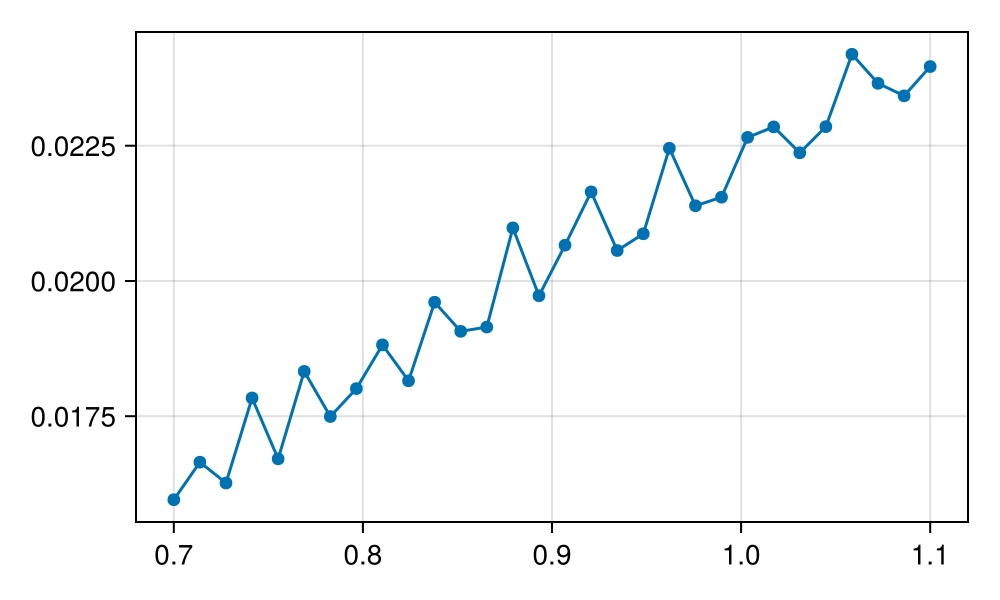

CairoMakie.Screen{IMAGE}


In [161]:
fig = cm.Figure(size = (500, 300))
ax = cm.Axis(fig[1,1])

cm.scatterlines!(ax, x_dat, y_dat)

display(fig)



In [165]:
savecube(quasienergies, "Data/TestQuasinergies")

LoadError: type DimArray has no field properties

DimArray{Float64, 3, Tuple{Dim{:state, DimensionalData.Dimensions.Lookups.Categorical{String, Vector{String}, DimensionalData.Dimensions.Lookups.Unordered, DimensionalData.Dimensions.Lookups.NoMetadata}}, Dim{:eps, DimensionalData.Dimensions.Lookups.Sampled{Float64, Vector{Float64}, DimensionalData.Dimensions.Lookups.ForwardOrdered, DimensionalData.Dimensions.Lookups.Irregular{Tuple{Nothing, Nothing}}, DimensionalData.Dimensions.Lookups.Points, DimensionalData.Dimensions.Lookups.NoMetadata}}, Dim{:shift, DimensionalData.Dimensions.Lookups.Sampled{Float64, Vector{Float64}, DimensionalData.Dimensions.Lookups.ForwardOrdered, DimensionalData.Dimensions.Lookups.Irregular{Tuple{Nothing, Nothing}}, DimensionalData.Dimensions.Lookups.Points, DimensionalData.Dimensions.Lookups.NoMetadata}}}, Tuple{}, Array{Float64, 3}, DimensionalData.NoName, DimensionalData.Dimensions.Lookups.NoMetadata}

In [193]:
savecube(YAXArray(quasienergies.dims, quasienergies.data), "Data/TestQuasienergies.nc", overwrite=true)

╭────────────────────────────────╮
│ 100×30×30 YAXArray{Float64, 3} │
├────────────────────────────────┴─────────────────────────────────────── dims ┐
  ↓ state Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered,
  → eps   Sampled{Float64} [0.7, 0.7137931034482758, …, 1.0862068965517242, 1.1] ForwardOrdered Irregular Points,
  ↗ shift Sampled{Float64} [0.03, 0.032413793103448274, …, 0.09758620689655173, 0.1] ForwardOrdered Irregular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any}()
├─────────────────────────────────────────────────────────────── loaded lazily ┤
  data size: 703.12 KB
└──────────────────────────────────────────────────────────────────────────────┘

In [196]:
703/(30*30)*(1000*1000)/1000

781.1111111111111

In [201]:
22/(30*30)*(200*200)/60

16.296296296296298

In [208]:
Dates.canonicalize(Dates.CompoundPeriod(now()))

LoadError: MethodError: no method matching Dates.CompoundPeriod(::DateTime)
The type `Dates.CompoundPeriod` exists, but no method is defined for this combination of argument types when trying to construct it.

[0mClosest candidates are:
[0m  Dates.CompoundPeriod([91m::Vector{Period}[39m)
[0m[90m   @[39m [36mDates[39m [90m~/.julia/juliaup/julia-1.11.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Dates/src/[39m[90m[4mperiods.jl:132[24m[39m
[0m  Dates.CompoundPeriod([91m::Time[39m)
[0m[90m   @[39m [36mDates[39m [90m~/.julia/juliaup/julia-1.11.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Dates/src/[39m[90m[4mperiods.jl:200[24m[39m
[0m  Dates.CompoundPeriod([91m::Period...[39m)
[0m[90m   @[39m [36mDates[39m [90m~/.julia/juliaup/julia-1.11.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Dates/src/[39m[90m[4mperiods.jl:203[24m[39m
[0m  ...


10

In [244]:
freq_d = Model.dressed_energies[(0,1)]-Model.dressed_energies[(2,0)]
εs = collect(LinRange(0.7, 1.1, 2));
shifts = collect(LinRange(0.03, 0.1, 2))
states = keys(Model.dressed_energies)
quasienergies = fill(0.0, Dim{:state}(string.(states)), Dim{:eps}(εs), Dim{:shift}(shifts))

avg_time = 0
start_time = now()

for j in 1:length(shifts)
    step_start = now()
    @info "Doing Shift Number: $(j)"
    params = []
    for i in 1:length(εs)
        push!(params, Dict{Any,Any}())
        params[end]["ε"] = εs[i]
        params[end]["ν"] = shifts[j]+freq_d
    end

    floq_sweep_res = SC.Dynamics.Floquet_t0_Sweep(Model, params; states_to_track=Model.dressed_states);

    

    for state in states
        #quasienergies[shifts[j]][state] = [floq_sweep_res[State = At(string(state))].data[i]["Quasienergies"] for i in 1:length(εs)]
        quasienergies[state = At(string(state)), shift=At(shifts[j])] = [floq_sweep_res[State = At(string(state))].data[i]["Quasienergies"] for i in 1:length(εs)]
    end
    step_end = now()
    @info "Step Run Time: "*string(Dates.canonicalize(step_end - step_start))
    
    println(round(Int, Dates.value(step_end - start_time)/j))
    avg_time = Dates.Millisecond(round(Int, Dates.value((step_end - start_time)/j)))
    expected_end = avg_time*(length(shifts)-j)
    @info "Average Time Per Step: "*string(Dates.canonicalize(avg_time))
    @info "Finishing in: "*string(Dates.canonicalize(expected_end))
    @info "--------------------------------------------------------------------------------"
    

end

end_time = now()

@info "Total Run Time: "*string(Dates.canonicalize(end_time - start_time))

[2024-12-17 10:49:57] Info: Doing Shift Number: 1
[2024-12-17 10:49:57] Info: Beginning Floquet Sweep
[2024-12-17 10:49:59] Info: Done With Floquet Sweep
[2024-12-17 10:49:59] Info: Tracking State
[2024-12-17 10:49:59] Info: Running the necessary time evolutions
[2024-12-17 10:49:59] Info: Step Run Time: 2 seconds, 761 milliseconds
2771
[2024-12-17 10:49:59] Info: Average Time Per Step: 2 seconds, 771 milliseconds
[2024-12-17 10:49:59] Info: Finishing in: 2 seconds, 771 milliseconds
[2024-12-17 10:49:59] Info: --------------------------------------------------------------------------------
[2024-12-17 10:49:59] Info: Doing Shift Number: 2
[2024-12-17 10:49:59] Info: Beginning Floquet Sweep
[2024-12-17 10:50:02] Info: Done With Floquet Sweep
[2024-12-17 10:50:02] Info: Tracking State
[2024-12-17 10:50:02] Info: Running the necessary time evolutions
[2024-12-17 10:50:02] Info: Step Run Time: 2 seconds, 640 milliseconds
2706
[2024-12-17 10:50:02] Info: Average Time Per Step: 2 seconds, 70

In [242]:
round(Int, 2686.5)

2686